<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Simple_method_Jan12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

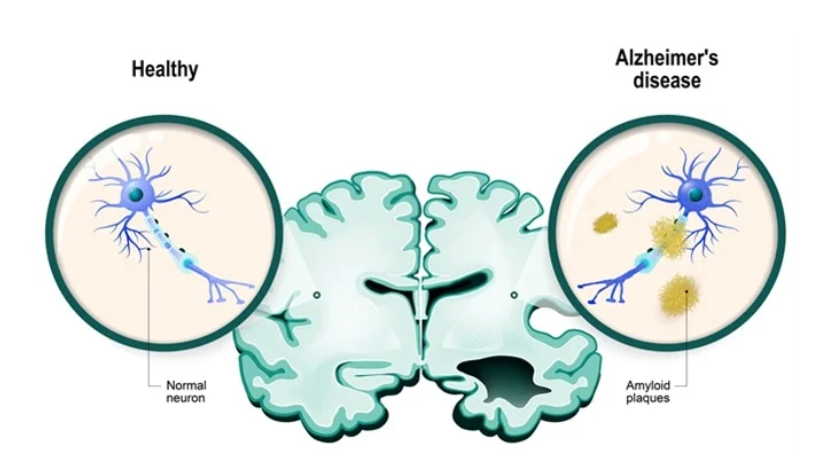

> Alzheimer's disease is the most common type of dementia. It is a progressive disease beginning with mild memory loss and possibly leading to loss of the ability to carry on a conversation and respond to the environment. Alzheimer's disease involves parts of the brain that control thought, memory, and language.



# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import seaborn as sns
import pathlib
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Download datasets directly from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("katalniraj/adni-extracted-axial")

print("Path to dataset files:", path)

100%|██████████| 102M/102M [00:06<00:00, 16.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/katalniraj/adni-extracted-axial/versions/1


> The kagglehub library is used to interact with Kaggle's datasets, models, and other resources. It provides functions to download datasets directly from Kaggle.

> The dataset_download function is used to download a dataset from Kaggle. The argument "katalniraj/adni-extracted-axial" specifies the dataset to download. This is the dataset's identifier on Kaggle, where katalniraj is the user who uploaded the dataset, and adni-extracted-axial is the name of the dataset.

> The function returns the path where the dataset is downloaded. This path is stored in the variable path.

> This line prints the path where the dataset files are stored. This is useful for verifying that the dataset has been downloaded correctly and to know where the files are located.



# Loading the Dataset for Training

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/root/.cache/kagglehub/datasets/katalniraj/adni-extracted-axial/versions/1/Axial",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/root/.cache/kagglehub/datasets/katalniraj/adni-extracted-axial/versions/1/Axial",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5154 files belonging to 3 classes.
Using 4124 files for training.
Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


> The image_dataset_from_directory function from TensorFlow's keras.preprocessing module is used to load images from a directory into a tf.data.Dataset object.



> Arguments:

"/root/.cache/kagglehub/datasets/katalniraj/adni-extracted-axial/versions/1": This is the path to the directory containing the dataset. It assumes that the dataset is organized in subdirectories, where each subdirectory represents a class.

validation_split=0.2: This specifies that 20% of the data should be reserved for validation.

subset="training": This indicates that the current dataset should contain the training portion of the data (80% in this case).

seed=1337: This sets a random seed for reproducibility when splitting the data into training and validation sets.

image_size=[180, 180]: This resizes all images to 180x180 pixels.

batch_size=16: This specifies that the dataset should be batched into groups of 16 images.

> The resulting train_ds is a tf.data.Dataset object that can be used for training a machine learning model.



## Summary
1. The code downloads a dataset from Kaggle using the kagglehub library.

2. It then loads the dataset into TensorFlow Dataset objects for both training and validation, with images resized to 180x180 pixels and batched into groups of 16.

3. The dataset is split into 80% training and 20% validation sets, with a fixed random seed for reproducibility.

## number and names of Classes

In [12]:
classnames = train_ds.class_names
len(classnames),train_ds.class_names

(3, ['AD', 'CI', 'CN'])

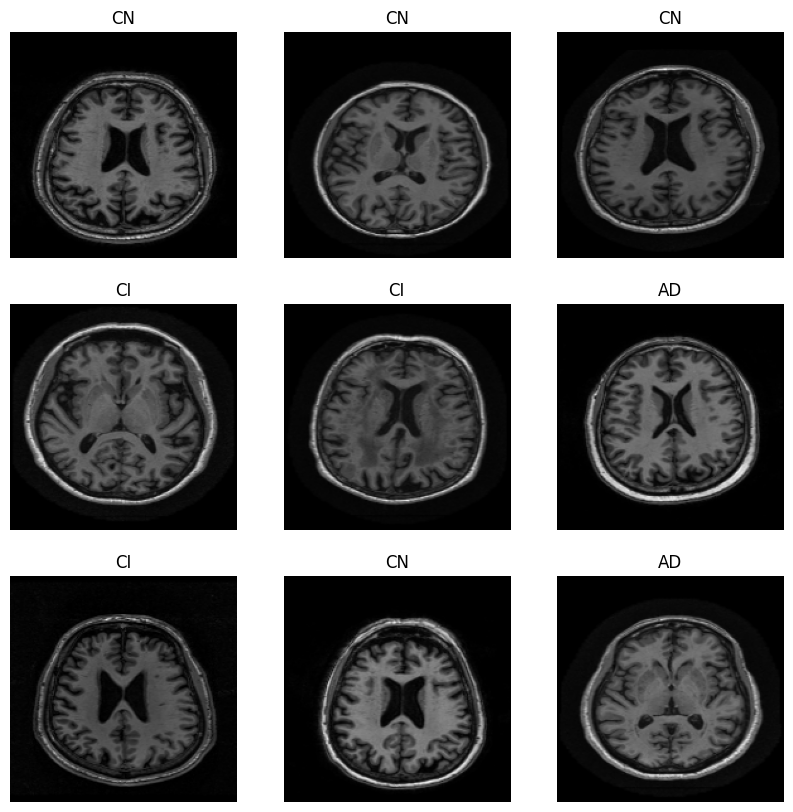

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")